# Growth Mechanism with Details

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors

sys.path.append('../../../src')
from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.viz.layout import imagemap, layout_fig, labelfigs
from m3_learning.RHEED.Dataset import RHEED_parameter_dataset, RHEED_spot_Dataset
from m3_learning.RHEED.Viz import Viz
from m3_learning.RHEED.Analysis import detect_peaks, analyze_curves, process_rheed_data, normalize_0_1, reset_tails, remove_linear_bg, denoise_fft, denoise_median
from m3_learning.RHEED.Packed_functions import decay_curve_examples
from m3_learning.RHEED.Analysis_umich import fit_curves, analyze_rheed_data, select_range, plot_activation_energy

plot_size = (6, 2)
color_blue = (44/255,123/255,182/255)
color_gray = (128/255, 128/255, 128/255, 0.5)
seq_colors = ['#00429d','#2e59a8','#4771b2','#5d8abd','#73a2c6','#8abccf','#a5d5d8','#c5eddf','#ffffe0']
bgc1, bgc2 = (*colors.hex2color(seq_colors[0]), 0.3), (*colors.hex2color(seq_colors[5]), 0.3)

## 1. Visualize the spots from collected data

In [4]:
para_path = '../Datasets/STO_PM29_gaussian_fit_parameters.h5'
ds_para = RHEED_parameter_dataset(para_path, camera_freq=1000, sample_name='PM29')
ds_para.dataset_names
# ds_para.data_info

['temp400_1', 'temp400_2', 'temp400_3']

## 2. Analyze the Decay Curve

#### cutoff

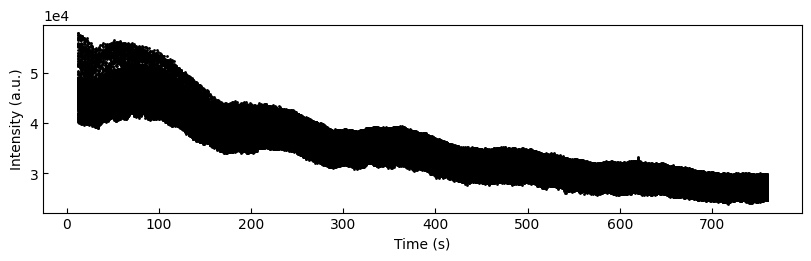

In [22]:
x, y = ds_para.load_curve(growth='temp400_1', spot='spot_2', metric='img_rec_sum', x_start=0)
data = np.stack([x, y], 1)
data = select_range(data, 12, 760)
x, y = data[:, 0], data[:, 1]

fig, ax1 = plt.subplots(1, 1, figsize=(8, 2.5), layout='compressed')
ax1.scatter(x, y, color='k', s=1)
Viz.set_labels(ax1, xlabel='Time (s)', ylabel='Intensity (a.u.)', ticks_both_sides=False)
plt.show()

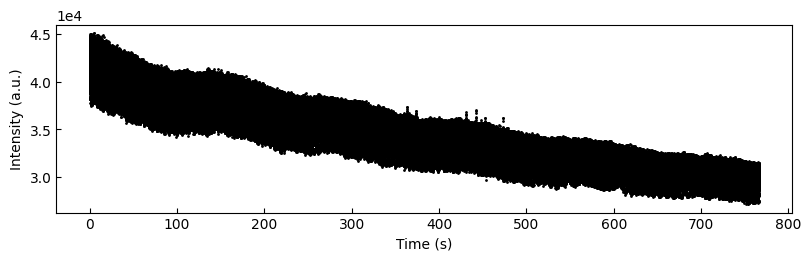

In [25]:
x, y = ds_para.load_curve(growth='temp400_2', spot='spot_2', metric='img_rec_sum', x_start=0)
data = np.stack([x, y], 1)
data = select_range(data, 0, 1000)
x, y = data[:, 0], data[:, 1]

fig, ax1 = plt.subplots(1, 1, figsize=(8, 2.5), layout='compressed')
ax1.scatter(x, y, color='k', s=1)
Viz.set_labels(ax1, xlabel='Time (s)', ylabel='Intensity (a.u.)', ticks_both_sides=False)
plt.show()

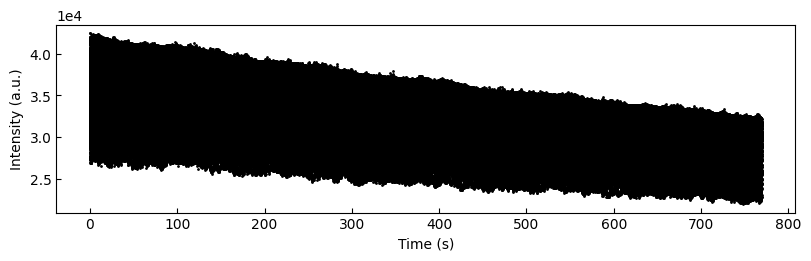

In [26]:
x, y = ds_para.load_curve(growth='temp400_3', spot='spot_2', metric='img_rec_sum', x_start=0)
data = np.stack([x, y], 1)
data = select_range(data, 0, 1000)
x, y = data[:, 0], data[:, 1]

fig, ax1 = plt.subplots(1, 1, figsize=(8, 2.5), layout='compressed')
ax1.scatter(x, y, color='k', s=1)
Viz.set_labels(ax1, xlabel='Time (s)', ylabel='Intensity (a.u.)', ticks_both_sides=False)
plt.show()

#### denoise params

img_sum-spot_1


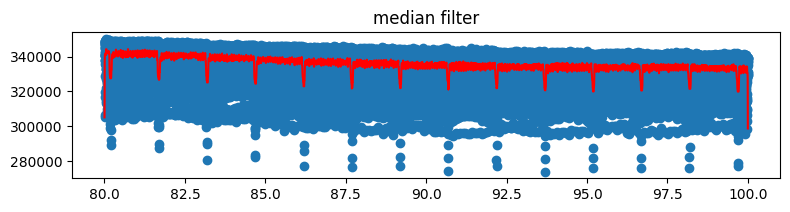

img_rec_sum-spot_1


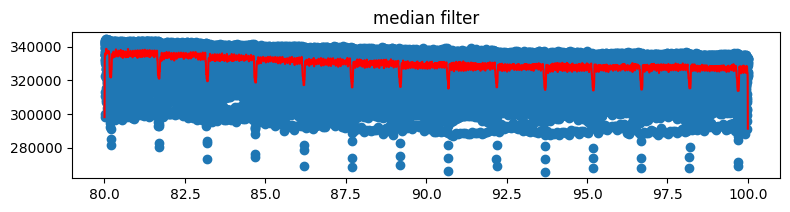

img_sum-spot_2


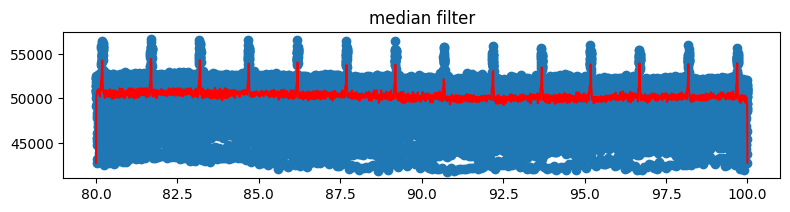

img_rec_sum-spot_2


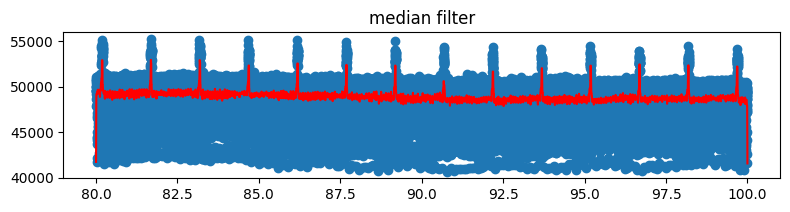

In [41]:
denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
savgol_window_order = denoise_params['savgol_window_order']
pca_component = denoise_params['pca_component']
fft_cutoff_order = denoise_params['fft_cutoff_order']
median_kernel_size = denoise_params['median_kernel_size'] 


for spot in ['spot_1', 'spot_2']:
    # for m in ["img_mean", "img_sum", "img_max", "img_rec_sum", "img_rec_max", "img_rec_mean", 
    #       "height", "x", "y", "width_x", "width_y"]:
    for m in ["img_sum", "img_rec_sum"]:
        sample_x, sample_y = ds_para.load_curve(growth='temp400_1', spot=spot, metric=m, x_start=0)
        data = np.stack([sample_x, sample_y], 1)
        data = select_range(data, 80, 100)
        print(m+'-'+spot)
        sample_x, sample_y = data[:, 0], data[:, 1]

        # denoised_sample_y = denoise_fft(sample_x, sample_y, cutoff_freq=10, denoise_order=3, sample_frequency=2000)
        denoised_sample_x, denoised_sample_y = denoise_median(sample_x, sample_y, kernel_size=median_kernel_size, viz=True)

temp400_1


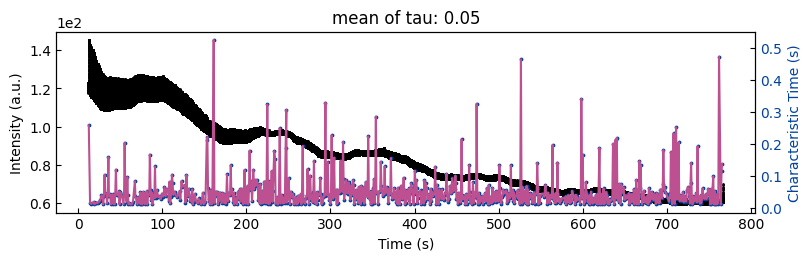

temp400_2


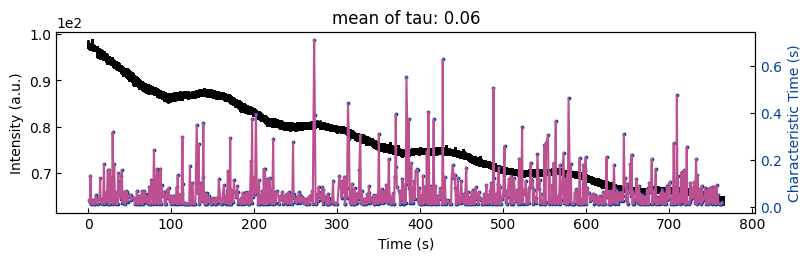

temp400_3


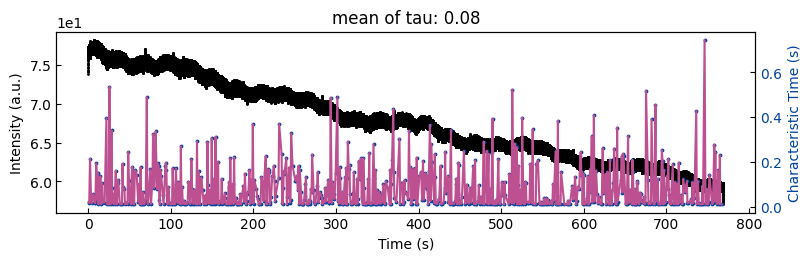

In [44]:
# denoise_params = {'savgol_window_order': (51,3), 'pca_component': 3, 'fft_cutoff_order':(20, 1), 'median_kernel_size':51}
denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
curve_params = {'trim_first':0, 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8}
normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 2], 'p_init':(1, 0.1, 0.1), 'n_std':1}
viz_params = {'viz_denoise': False, 'viz_raw_curves':False, 'per_plot':10, 'viz_processed_curves': False, 'viz_fittings': False, 
              'viz_ab': False, 'viz_tau': True}
    
laser_freq = 1
camera_freq = 1000

ranges_list = [(12, 1000), (0, 1000), (0, 1000)]
temp_list = ['temp400_1', 'temp400_2', 'temp400_3']
tau_list = []

for temp, ranges in zip(temp_list, ranges_list):
    sample_x, sample_y = ds_para.load_curve(growth=temp, spot='spot_2', metric='img_rec_max', x_start=0)
    print(temp)
    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, *ranges)

    parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)
    tau_list.append(tau)

temp350


c:\Users\yig319\Anaconda3\envs\m3\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
../../src\m3_learning\RHEED\Analysis_umich.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys_nor_all = np.array(ys_nor_all)
../../src\m3_learning\RHEED\Analysis_umich.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested seq

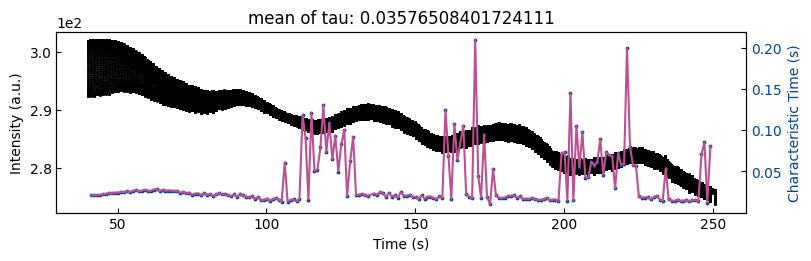

temp400


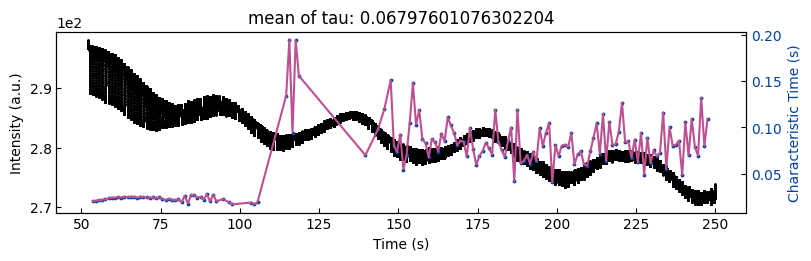

temp450


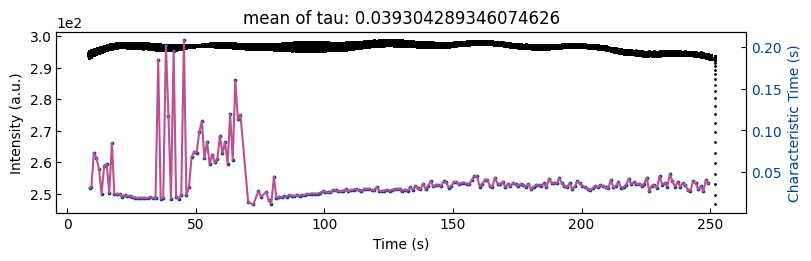

temp800


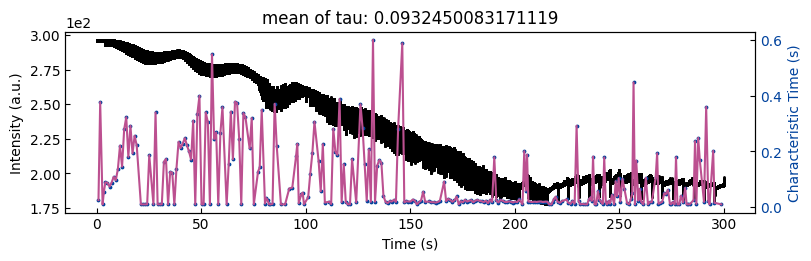

In [13]:
# denoise_params = {'savgol_window_order': (51,3), 'pca_component': 3, 'fft_cutoff_order':(20, 1), 'median_kernel_size':51}
denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
curve_params = {'trim_first':0, 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8}
normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 2], 'p_init':(1, 0.1, 0.1), 'n_std':1}
viz_params = {'viz_denoise': False, 'viz_curves': False, 'viz_fittings': False, 'viz_ab': False}
    
laser_freq = 1
camera_freq = 1000

ranges_list = [(40, 300), (52, 250), (8, 300), (0, 300)]
temp_list = ['temp350', 'temp400', 'temp450', 'temp800']
tau_list = []

for temp, ranges in zip(temp_list, ranges_list):
    sample_x, sample_y = ds_para.load_curve(growth=temp, spot='spot_2', metric='img_rec_max', x_start=0)
    print(temp)
    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, *ranges)

    parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)
    tau_list.append(tau)

In [ ]:

for tau in tau_list:
    tau_mean_list.append(np.mean(tau))

In [19]:
T_list = [350, 400, 450, 800]

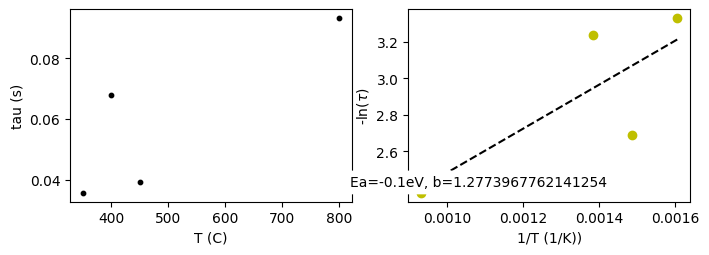

In [20]:
plot_activation_energy(T_list, tau_list)

In [21]:
np.save('./Saved_data/tau_PM11_350C.npy', tau_list[0])
np.save('./Saved_data/tau_PM12_400C.npy', tau_list[1])
np.save('./Saved_data/tau_PM14_450C.npy', tau_list[2])
np.save('./Saved_data/tau_PM17_800C.npy', tau_list[3])

In [25]:
int('./Saved_data/tau_PM04_350C.npy'.split('_')[-1][:3])

350

In [26]:
import glob

In [37]:
T_list, tau_list = [], []
for file in glob.glob('./Saved_data/tau_*.npy'):
    T_list.append(int(file.split('_')[-1][:3]))
    tau_list.append(np.load(file))

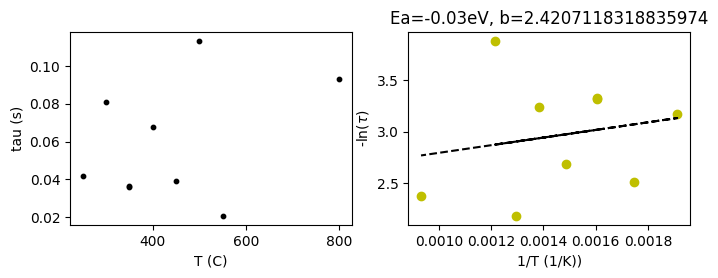

In [39]:
plot_activation_energy(T_list, tau_list)

In [32]:
tau_mean_list = []
for tau in tau_list:
    tau_mean_list.append(np.mean(tau)) 

In [34]:
T_list

[350, 300, 250, 500, 550, 550, 350, 400, 450, 800]

In [36]:
tau_mean_list

[0.03636850302771958,
 0.08112922840333983,
 0.04172169175129359,
 0.11332824321866607,
 0.020567949832358507,
 0.020567949832358507,
 0.03576508401724111,
 0.06797601076302204,
 0.039304289346074626,
 0.0932450083171119]